# Detecção de logos e assinaturas

In [45]:
# Importação das bibliotecas
import xml.etree.ElementTree as ET
import os, sys, json, shutil, zipfile
import tensorflow as tf
import pandas as pd
import numpy as np
import locale
import cv2
from glob import glob
from IPython.display import display
from google.colab import userdata, drive
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [24]:
# Caminho completo do diretório .kaggle
kaggle_folder = os.path.expanduser('~/.kaggle')

# Cria o diretório se não existir
os.makedirs(kaggle_folder, exist_ok=True)

# Caminho completo do arquivo JSON de autenticação
kaggle_auth_file = os.path.join(kaggle_folder, 'kaggle.json')

# Cria o arquivo JSON de autenticação
with open(kaggle_auth_file, 'w') as jsonFile:
    json.dump({
        'username': userdata.get('kaggle_usr'),
        'key': userdata.get('kaggle_key')
    }, jsonFile)

# Define as permissões do arquivo
os.chmod(kaggle_auth_file, 0o600)

print('Arquivo JSON de autenticação criado com sucesso em:', kaggle_auth_file)

Arquivo JSON de autenticação criado com sucesso em: /root/.kaggle/kaggle.json


In [25]:
# Instalar o pacote kaggle
!pip install kaggle

In [26]:
# Excluir diretório existente
if os.path.exists('/content/datasets/'):
    shutil.rmtree('/content/datasets/')

# Cria o diretório se não existir
os.makedirs('/content/datasets/raw/', exist_ok=True)

# Fazer download do dataset
!kaggle datasets download -d kaiquanmah/tobacco800-with-ground-truth --path /content/datasets/raw --force

Dataset URL: https://www.kaggle.com/datasets/kaiquanmah/tobacco800-with-ground-truth
License(s): unknown
 95% 31.0M/32.8M [00:02<00:00, 21.2MB/s]
100% 32.8M/32.8M [00:02<00:00, 14.0MB/s]


In [27]:
!unzip /content/datasets/raw/tobacco800-with-ground-truth.zip -d /content/datasets/raw/tobacco800-with-ground-truth/

Archive:  /content/datasets/raw/tobacco800-with-ground-truth.zip
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/Overview of Tobacco800 Groundtruth_v2.0.txt  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/aah97e00-page02_1.xml  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/aah97e00-page02_2.xml  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/aam09c00.xml  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/aao54e00_1.xml  
  inflating: /content/datasets/raw/tobacco800-with-ground-truth/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/a

In [28]:
# Define os caminhos para acessar o dataset e os arquivos associados à fonte de dados.
source_dataset_path = '/content/datasets/raw/tobacco800-with-ground-truth'
source_images_path = f'{source_dataset_path}/Tobacco800_SinglePage/Tobacco800_SinglePage/SinglePageTIF'
source_annotation_files_path = f'{source_dataset_path}/Tobacc800_Groundtruth_v2.0/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0'

# Lista em ordem alfabética todos os arquivos XML dentro do diretório especificado
annotation_files = sorted(glob(f'{source_annotation_files_path}/*.xml'))

# Inicializa uma lista para armazenar informações extraídas dos arquivos XML
extracted_data = []

# Coletar todas as categorias de todos os nós para treinamento do LabelEncoder
all_categories = []
for file_path in annotation_files:
    root_element = ET.parse(file_path).getroot()
    for node in root_element[0][0]:
        all_categories.append(node.attrib.get('gedi_type'))

# Treinar o LabelEncoder com todas as categorias coletadas
label_encoder = LabelEncoder()
label_encoder.fit(all_categories)

# Processar cada arquivo XML
for file_path in annotation_files:
    root_element = ET.parse(file_path).getroot()
    file_name = root_element[0].attrib.get('src')
    page_height = root_element[0][0].attrib.get('height')
    page_width = root_element[0][0].attrib.get('width')

    # Extrair informações de cada nó na página
    for node in root_element[0][0]:
        id = node.attrib.get('id')
        gedi_type = node.attrib.get('gedi_type')
        labels = label_encoder.transform([gedi_type])

        x, y = node.attrib.get('col'), node.attrib.get('row')
        w, h = node.attrib.get('width'), node.attrib.get('height')

        if gedi_type == 'DLSignature':
            author = node.attrib.get('AuthorID')
            is_overlapped = node.attrib.get('Overlapped')
        else:
            author, is_overlapped = ('NA', 'NA')

        # Construir linha com os dados essenciais
        row = [file_name, gedi_type, labels, x, y, w, h, page_width, page_height, author, is_overlapped, id]
        extracted_data.append(row)

# Criar um DataFrame com os dados extraídos
xml_extracted_data = pd.DataFrame(extracted_data, columns=[
    'file_name', 'gedi_type', 'labels', 'x', 'y', 'w', 'h',
    'page_width', 'page_height', 'author', 'is_overlapped', 'id'
])
xml_extracted_data.head(10)

,file_name,gedi_type,labels,x,y,w,h,page_width,page_height,author,is_overlapped,id
0,aah97e00-page02_1.tif,DLLogo,[0],1074,18,374,219,2560,3296,NA,NA,None
1,aah97e00-page02_2.tif,DLSignature,[1],1409,793,659,361,2560,3296,"Boder, J.B.",Yes,None
2,aam09c00.tif,DLSignature,[1],821,1422,757,183,1728,2292,"Koplow, M.G.",Yes,None
3,aao54e00_2.tif,DLSignature,[1],1514,708,627,206,2560,3296,"Landry, J.T.",Yes,None
4,abm69c00.tif,DLSignature,[1],667,1279,617,110,1728,2292,"Feldman, J.D.",Yes,None
5,acr64d00.tif,DLSignature,[1],886,1801,463,181,1728,2292,"Boffa, J.R.",Yes,None
6,adh36e00-page2_1.tif,DLLogo,[0],1181,18,359,219,2560,3245,NA,NA,None
7,adh36e00-page2_2.tif,DLSignature,[1],1232,2399,896,431,2560,3246,"Krivisky, B.M.",Yes,None
8,adh36e00_1.tif,DLLogo,[0],1187,18,347,219,2560,3245,NA,NA,None
9,adh36e00_2.tif,DLSignature,[1],1239,2403,889,434,2560,3246,"Krivisky, B.M.",Yes,None


In [29]:
dataset_name = 'tobacco800'
target_dataset_path = f'/content/datasets/{dataset_name}'
target_resized_images_path = f'{target_dataset_path}/images/resized'

# Excluir diretório existente
if os.path.exists(target_resized_images_path):
    shutil.rmtree(target_resized_images_path)

# Cria o diretório se não existir
os.makedirs(target_resized_images_path, exist_ok=True)

In [30]:
# Redimensionando as imagens para reduzir o tempo de treinamento
def resizing_extracted_data(data):
    resized_data = []

    for file, labels, x, y, w, h in zip(data.file_name, data.labels, map(int, data.x), map(int, data.y), map(int, data.w), map(int, data.h)):
        image_path = f'{source_images_path}/{file}'
        image = cv2.imread(image_path, 1)

        page_height, page_width = image.shape[:2]
        max_height = 640
        max_width = 480

        resize_factor = min(max_height / page_height, max_width / page_width)

        if resize_factor < 1:
            image = cv2.resize(image, None, fx=resize_factor, fy=resize_factor, interpolation=cv2.INTER_AREA)

        resized_file_name = f'{file[:-4]}.jpg'
        cv2.imwrite(f'{target_resized_images_path}/{resized_file_name}', image)

        # Salva novas dimensões da página
        resized_page_width, resized_page_height = int(page_width * resize_factor), int(page_height * resize_factor)

        # Calcula novas coordenadas x, y, w, h após redimensionamento
        resized_x, resized_y, resized_w, resized_h = int(x * resize_factor), int(y * resize_factor), int(w * resize_factor), int(h * resize_factor)

        row = [resized_file_name, labels, resized_x, resized_y, resized_w, resized_h, resized_page_width, resized_page_height]
        resized_data.append(row)
    return resized_data

resized_data = resizing_extracted_data(xml_extracted_data)

resized_data = pd.DataFrame(resized_data, columns=['file_name', 'labels', 'x', 'y', 'w', 'h', 'page_width', 'page_height'])
resized_data.head(10)

,file_name,labels,x,y,w,h,page_width,page_height
0,aah97e00-page02_1.jpg,[0],201,3,70,41,480,618
1,aah97e00-page02_2.jpg,[1],264,148,123,67,480,618
2,aam09c00.jpg,[1],228,395,210,50,480,636
3,aao54e00_2.jpg,[1],283,132,117,38,480,618
4,abm69c00.jpg,[1],185,355,171,30,480,636
5,acr64d00.jpg,[1],246,500,128,50,480,636
6,adh36e00-page2_1.jpg,[0],221,3,67,41,480,608
7,adh36e00-page2_2.jpg,[1],231,449,168,80,480,608
8,adh36e00_1.jpg,[0],222,3,65,41,480,608
9,adh36e00_2.jpg,[1],232,450,166,81,480,608


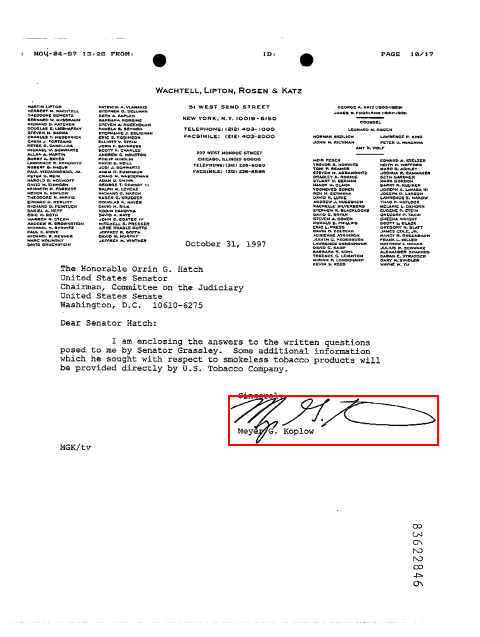

In [31]:
# Teste do redimensionamento das imagens e suas respectivas anotações.
def draw_boxes_on_image(data):
    file, x, y, w, h = data.file_name, data.x, data.y, data.w, data.h
    image = Image.open(f'{target_resized_images_path}/{file}')
    draw = ImageDraw.Draw(image)
    draw.rectangle([(x, y), (x + w, y + h)], outline='red', width=2)
    display(image)
draw_boxes_on_image(resized_data.iloc[2])

In [32]:
train_data, valid_data = train_test_split(resized_data, test_size=0.1, random_state=13, shuffle=True)
print(train_data.shape, valid_data.shape)

(1207, 8) (135, 8)


In [33]:
target_val_images_path = f'{target_dataset_path}/images/val'
target_val_labels_path = f'{target_dataset_path}/labels/val'
target_train_images_path = f'{target_dataset_path}/images/train'
target_train_labels_path = f'{target_dataset_path}/labels/train'

# Excluir diretório existente
if os.path.exists(target_val_images_path):
    shutil.rmtree(target_val_images_path)

if os.path.exists(target_val_labels_path):
    shutil.rmtree(target_val_labels_path)

if os.path.exists(target_train_images_path):
    shutil.rmtree(target_train_images_path)

if os.path.exists(target_train_labels_path):
    shutil.rmtree(target_train_labels_path)

# Cria o diretório se não existir
os.makedirs(target_val_images_path, exist_ok=True)
os.makedirs(target_val_labels_path, exist_ok=True)
os.makedirs(target_train_images_path, exist_ok=True)
os.makedirs(target_train_labels_path, exist_ok=True)

In [34]:
def yolo_format(data):
    x, y, w, h, page_width, page_height = data.x, data.y, data.w, data.h, data.page_width, data.page_height

    x_center = int(x + (w / 2))
    y_center = int(y + (h / 2))

    normalized_x = x_center / page_width
    normalized_y = y_center / page_height

    normalized_w = w / page_width
    normalized_h = h / page_height

    return [normalized_x, normalized_y, normalized_w, normalized_h]

def segregate_data(data, source_images_path, target_images_path, target_labels_path):
    # Obter nomes de arquivos únicos
    file_names = set(data['file_name'])

    for file_name in file_names:
        yolo_list = []

        # Filtrar linhas para o arquivo atual
        file_data = data[data['file_name'] == file_name]

        for _, row in file_data.iterrows():
            yolo_list.append([row.labels[0], *yolo_format(row)])

        # Converter yolo_list em array NumPy
        yolo_list = np.array(yolo_list)

        # Salvar os dados em arquivos TXT
        txt_file_name = os.path.join(target_labels_path, f'{file_name.split(".")[0]}.txt')
        np.savetxt(txt_file_name, yolo_list, fmt=['%d', '%f', '%f', '%f', '%f'])

        # Copiar as imagens de origem para o destino
        source_images = os.path.join(source_images_path, file_name)
        target_images = os.path.join(target_images_path, file_name)
        shutil.copyfile(source_images, target_images)

segregate_data(train_data, target_resized_images_path, target_train_images_path, target_train_labels_path)
segregate_data(valid_data, target_resized_images_path, target_val_images_path, target_val_labels_path)

# Número de arquivos de imagem e rótulos nos diretórios de treinamento e validação
print('Número de imagens de treinamento:', len(os.listdir(target_train_images_path)))
print('Número de rótulos de treinamento:', len(os.listdir(target_train_labels_path)))
print('Número de imagens de validação:', len(os.listdir(target_val_images_path)))
print('Número de rótulos de validação:', len(os.listdir(target_val_labels_path)))

Número de imagens de treinamento: 807
Número de rótulos de treinamento: 807
Número de imagens de validação: 129
Número de rótulos de validação: 129


In [35]:
# Remover arquivo `.ipynb_checkpoints` criado automaticamente em diretórios e subdiretórios
!find /content/ -type f -name '.ipynb_checkpoints' -exec rm {} +

In [36]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Não conectado a uma GPU.')
else:
  print(gpu_info)

Wed May  1 21:32:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   34C    P8              16W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [42]:
# Integração com a API do GitHub
%pip install PyGithub
from github import Github

# Criando uma instância do PyGithub com um token de acesso pessoal
github_access = Github(userdata.get('github_token'))

# Obtendo o repositório
github_repo = github_access.get_repo('ronaldo-fs/signature-detection')

# Obtendo o conteúdo do arquivo
contents = github_repo.get_contents('src/tobacco800.yaml', ref='fix/source-files')

# Define o caminho completo do arquivo
tobacco800_config_file = os.path.join('/content/datasets', f'{dataset_name}.yaml')

# Escrevendo o conteúdo em um arquivo local
with open(tobacco800_config_file, 'wb') as file:
    file.write(contents.decoded_content)

print('Arquivo salvo em:', tobacco800_config_file)

Arquivo salvo em: /content/datasets/tobacco800.yaml


In [38]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.6 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Setup complete ✅ (16 CPUs, 62.8 GB RAM, 29.0/201.2 GB disk)


In [44]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')
model = YOLO('yolov8n.pt')
model = YOLO('yolov8n.yaml').load('yolov8n.pt')

results = model.train(data='/content/datasets/tobacco800.yaml', task='detect', epochs=100, imgsz=640, patience=100)

Transferred 355/355 items from pretrained weights
Ultralytics YOLOv8.2.6 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/datasets/tobacco800.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fa

100%|██████████| 755k/755k [00:00<00:00, 117MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n summary: 225 layers, 3011238 parameters, 3011222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train4', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /content/datasets/tobacco800/labels/train... 807 images, 0 backgrounds, 0 corrupt: 100%|██████████| 807/807 [00:00<00:00, 1436.43it/s]

train: New cache created: /content/datasets/tobacco800/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/tobacco800/labels/val... 129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 129/129 [00:00<00:00, 1182.43it/s]

val: New cache created: /content/datasets/tobacco800/labels/val.cache


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.16G       1.56      2.924      1.186         16        640: 100%|██████████| 51/51 [00:07<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        129        135     0.0034      0.959      0.211       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.1G      1.311      1.833      1.067         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


                   all        129        135       0.49      0.724      0.523      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.11G      1.241      1.571      1.067         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.27it/s]

                   all        129        135      0.539      0.742      0.561      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.1G       1.25      1.434      1.065         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.35it/s]

                   all        129        135      0.474        0.8      0.527      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.1G      1.203      1.295      1.057         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.23it/s]

                   all        129        135      0.482      0.692      0.517      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.1G      1.163      1.193      1.033         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.52it/s]

                   all        129        135      0.474      0.851      0.572      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.1G      1.169      1.117      1.041         12        640: 100%|██████████| 51/51 [00:04<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.79it/s]

                   all        129        135      0.545      0.663       0.52      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.1G      1.136      1.064       1.02         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.09it/s]

                   all        129        135      0.549      0.809      0.562      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       2.1G      1.102     0.9853      1.009         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]

                   all        129        135      0.538      0.646      0.541      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       2.1G      1.084     0.9486     0.9997         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.18it/s]

                   all        129        135      0.527      0.732      0.588      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       2.1G      1.088      0.928       1.01         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.12it/s]

                   all        129        135      0.549      0.849      0.583      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.09G      1.052     0.8893     0.9862         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.97it/s]

                   all        129        135      0.538      0.855      0.605       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       2.1G      1.041      0.852     0.9857         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.21it/s]

                   all        129        135      0.538      0.834       0.59      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.1G      1.037     0.8436     0.9802         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.23it/s]

                   all        129        135      0.553       0.79      0.573      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       2.1G      1.056      0.846     0.9918         11        640: 100%|██████████| 51/51 [00:04<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.89it/s]

                   all        129        135      0.544      0.756       0.54      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.09G      1.046     0.8521     0.9862         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.00it/s]

                   all        129        135      0.518      0.889      0.585       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.1G      1.021      0.799     0.9779         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.99it/s]

                   all        129        135      0.529      0.867      0.608      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       2.1G      1.016     0.8075     0.9748         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.09it/s]

                   all        129        135      0.543      0.869      0.597      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       2.1G       0.98     0.7492     0.9608         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.09it/s]

                   all        129        135      0.524      0.881      0.604      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.09G     0.9867     0.7722     0.9635         26        640: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.28it/s]

                   all        129        135      0.521      0.898      0.592      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       2.1G     0.9954     0.8086      0.964         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]

                   all        129        135      0.529      0.882      0.575      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       2.1G     0.9991     0.7689     0.9678         24        640: 100%|██████████| 51/51 [00:04<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.17it/s]

                   all        129        135      0.544      0.865      0.542      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       2.1G      0.954     0.7508     0.9624         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.33it/s]

                   all        129        135      0.526      0.844      0.616      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.09G     0.9949      0.773     0.9718         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.15it/s]

                   all        129        135      0.527      0.886      0.562      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       2.1G     0.9494     0.7355     0.9492         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.08it/s]

                   all        129        135      0.536      0.878      0.554       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       2.1G     0.9694     0.7338     0.9611         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.27it/s]

                   all        129        135      0.531      0.854      0.562      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       2.1G     0.9484     0.7323     0.9498         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.05it/s]

                   all        129        135       0.53      0.707      0.536      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.09G     0.9514     0.7301     0.9445         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.92it/s]

                   all        129        135      0.508      0.855      0.577      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.11G     0.9354     0.7172     0.9537         11        640: 100%|██████████| 51/51 [00:04<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.37it/s]

                   all        129        135       0.53      0.888      0.576      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.1G     0.9305     0.7016     0.9527         21        640: 100%|██████████| 51/51 [00:04<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.99it/s]

                   all        129        135      0.534      0.843      0.602      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.1G     0.8972     0.6689     0.9359         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.94it/s]

                   all        129        135      0.509      0.885      0.555      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.09G     0.9108     0.6707     0.9387         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.99it/s]

                   all        129        135        0.5      0.918      0.604      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.1G     0.9353     0.6885      0.942         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.84it/s]

                   all        129        135      0.554      0.875      0.574      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       2.1G     0.9133     0.6672     0.9348         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.14it/s]

                   all        129        135      0.481      0.891      0.523      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.1G     0.9015     0.6664     0.9364         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.43it/s]

                   all        129        135      0.524      0.881      0.581      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.09G     0.9204     0.6911     0.9447         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.17it/s]

                   all        129        135      0.466      0.785      0.545      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.11G     0.9011     0.6743     0.9325         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.44it/s]

                   all        129        135      0.515      0.849      0.582      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.1G     0.8882     0.6478     0.9254         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.34it/s]

                   all        129        135      0.526      0.822      0.555      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.1G        0.9     0.6581     0.9328          8        640: 100%|██████████| 51/51 [00:04<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.09it/s]

                   all        129        135      0.534      0.854      0.572      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.09G     0.8623     0.6487     0.9285          9        640: 100%|██████████| 51/51 [00:04<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.27it/s]

                   all        129        135      0.534      0.879      0.545      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       2.1G     0.8954     0.6389     0.9335         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.05it/s]

                   all        129        135      0.488      0.821      0.518      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.1G     0.8865     0.6317     0.9248         26        640: 100%|██████████| 51/51 [00:04<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.15it/s]

                   all        129        135      0.533      0.869      0.565      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       2.1G     0.8799     0.6415      0.927         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.22it/s]

                   all        129        135      0.513      0.884      0.589      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.09G     0.8669     0.6214     0.9291         10        640: 100%|██████████| 51/51 [00:04<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.30it/s]

                   all        129        135      0.544      0.847      0.577      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.1G     0.8623     0.6353     0.9324         26        640: 100%|██████████| 51/51 [00:04<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.77it/s]

                   all        129        135      0.525      0.911      0.593      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.11G     0.8841     0.6243     0.9323         22        640: 100%|██████████| 51/51 [00:04<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.03it/s]

                   all        129        135      0.501      0.866      0.597       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.1G     0.8732     0.6186     0.9254         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.31it/s]

                   all        129        135      0.515      0.883      0.603      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.09G      0.866     0.6216     0.9323         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.26it/s]

                   all        129        135      0.509      0.886      0.598      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       2.1G      0.861     0.6178     0.9215         11        640: 100%|██████████| 51/51 [00:04<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.22it/s]

                   all        129        135       0.56      0.837      0.605      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.1G     0.8633     0.6006     0.9136         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.12it/s]

                   all        129        135      0.523      0.851      0.553      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       2.1G     0.8499     0.6029     0.9117         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.83it/s]

                   all        129        135      0.511      0.891       0.57      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.09G     0.8172     0.5907     0.9142         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.26it/s]

                   all        129        135      0.503      0.882      0.586      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.1G     0.8303     0.5884     0.9205         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.05it/s]

                   all        129        135        0.5      0.899      0.566      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.11G     0.8379     0.5806     0.9177         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.96it/s]

                   all        129        135      0.527      0.814      0.568       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       2.1G     0.8249     0.5743     0.9063         19        640: 100%|██████████| 51/51 [00:04<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.19it/s]

                   all        129        135      0.496      0.864      0.595      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.09G     0.8168      0.555     0.9096         25        640: 100%|██████████| 51/51 [00:04<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.44it/s]

                   all        129        135      0.491      0.892       0.56      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.1G     0.8112     0.5603      0.911         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.29it/s]

                   all        129        135      0.525      0.865      0.564       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.1G     0.8051     0.5717     0.9093         12        640: 100%|██████████| 51/51 [00:04<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.40it/s]

                   all        129        135      0.534      0.867      0.546      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       2.1G     0.8097     0.5809     0.9093         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]

                   all        129        135      0.517      0.846      0.569      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.09G       0.81     0.5744     0.9072         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.26it/s]

                   all        129        135      0.499      0.882      0.559      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.1G     0.8298     0.5864      0.906         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.30it/s]

                   all        129        135      0.515      0.856      0.529       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.11G     0.8056     0.5581     0.9091         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.30it/s]

                   all        129        135      0.513      0.885      0.549      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       2.1G     0.8146     0.5688     0.9056         23        640: 100%|██████████| 51/51 [00:04<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.11it/s]

                   all        129        135      0.505      0.891      0.552      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.09G     0.8005     0.5668      0.908         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.03it/s]

                   all        129        135      0.504      0.869      0.592      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.1G     0.8083     0.5667     0.9061         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.28it/s]

                   all        129        135      0.518      0.857      0.559      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       2.1G     0.7687     0.5387     0.8945         12        640: 100%|██████████| 51/51 [00:04<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.11it/s]

                   all        129        135      0.511      0.905      0.532      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       2.1G     0.7927     0.5647     0.8995         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.19it/s]

                   all        129        135      0.507      0.897      0.566       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.09G     0.7871     0.5459      0.903         29        640: 100%|██████████| 51/51 [00:04<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.12it/s]

                   all        129        135      0.504      0.895      0.557      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       2.1G     0.7711     0.5277     0.8887         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.40it/s]

                   all        129        135      0.515      0.878      0.553      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       2.1G      0.783     0.5385      0.902         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.29it/s]

                   all        129        135      0.499      0.894      0.542      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.1G     0.7822     0.5412     0.8996         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.43it/s]

                   all        129        135      0.507      0.855      0.583      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.09G     0.7706     0.5257      0.894         22        640: 100%|██████████| 51/51 [00:04<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.94it/s]

                   all        129        135      0.505      0.869      0.555      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       2.1G     0.7619     0.5324     0.8929         23        640: 100%|██████████| 51/51 [00:04<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]

                   all        129        135      0.511      0.841      0.554      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.1G     0.7626     0.5395     0.9001         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.34it/s]

                   all        129        135      0.507      0.881      0.542      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       2.1G     0.7719     0.5283     0.8972         27        640: 100%|██████████| 51/51 [00:04<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.49it/s]

                   all        129        135      0.498      0.906      0.563      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.09G     0.7743     0.5216     0.8874         18        640: 100%|██████████| 51/51 [00:04<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.32it/s]

                   all        129        135      0.507      0.857       0.56      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.11G      0.758     0.5132     0.8888         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.36it/s]

                   all        129        135      0.499      0.857      0.572      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.1G     0.7591     0.5234     0.8926         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.90it/s]

                   all        129        135      0.508      0.872      0.551      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       2.1G     0.7498     0.5211     0.8897         21        640: 100%|██████████| 51/51 [00:04<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.32it/s]

                   all        129        135      0.513      0.863      0.573      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.09G     0.7532     0.5161     0.8902         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.27it/s]

                   all        129        135      0.514      0.888      0.569      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.11G     0.7266      0.493     0.8834         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.19it/s]

                   all        129        135      0.504      0.873      0.547      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       2.1G     0.7547     0.5021     0.8931         22        640: 100%|██████████| 51/51 [00:04<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.86it/s]

                   all        129        135       0.51      0.862      0.537      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       2.1G      0.749     0.5072     0.8927         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.35it/s]

                   all        129        135      0.509      0.861      0.538       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.09G     0.7392     0.4995     0.8841         23        640: 100%|██████████| 51/51 [00:04<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.26it/s]

                   all        129        135      0.501      0.863      0.547      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       2.1G     0.7372     0.5021     0.8822         14        640: 100%|██████████| 51/51 [00:04<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.00it/s]

                   all        129        135      0.503      0.871      0.537      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       2.1G     0.7362     0.4886     0.8878          9        640: 100%|██████████| 51/51 [00:04<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.33it/s]

                   all        129        135      0.501      0.895      0.532      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       2.1G     0.7081     0.4742     0.8751         20        640: 100%|██████████| 51/51 [00:04<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.36it/s]

                   all        129        135      0.494      0.904      0.532      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.09G     0.7274     0.4758     0.8828         15        640: 100%|██████████| 51/51 [00:04<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.31it/s]

                   all        129        135      0.491      0.863      0.518      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       2.1G     0.7375     0.4923     0.8904         17        640: 100%|██████████| 51/51 [00:04<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.02it/s]

                   all        129        135      0.492      0.905      0.536      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       2.1G     0.7161      0.483     0.8943         13        640: 100%|██████████| 51/51 [00:04<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.82it/s]

                   all        129        135      0.491      0.883      0.537      0.453


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.1G     0.6612     0.4242     0.8715          9        640: 100%|██████████| 51/51 [00:05<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.17it/s]

                   all        129        135      0.495      0.868      0.535       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.09G     0.6439     0.4239     0.8573          8        640: 100%|██████████| 51/51 [00:04<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.48it/s]

                   all        129        135      0.497      0.872      0.512       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.1G     0.6454     0.4263     0.8644          9        640: 100%|██████████| 51/51 [00:04<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.45it/s]

                   all        129        135      0.495      0.876      0.531      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.1G     0.6515     0.4252     0.8596          9        640: 100%|██████████| 51/51 [00:04<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.13it/s]

                   all        129        135       0.49      0.899      0.532      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       2.1G     0.6425     0.4115     0.8579          7        640: 100%|██████████| 51/51 [00:04<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.37it/s]

                   all        129        135      0.489      0.855      0.534      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.09G     0.6185     0.4027     0.8537         16        640: 100%|██████████| 51/51 [00:04<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.34it/s]

                   all        129        135      0.485      0.848      0.527      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       2.1G     0.6247     0.4064     0.8488         10        640: 100%|██████████| 51/51 [00:04<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.34it/s]

                   all        129        135      0.492      0.861      0.524      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       2.1G     0.6273     0.4034     0.8558         12        640: 100%|██████████| 51/51 [00:04<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.22it/s]

                   all        129        135      0.494      0.861      0.524      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       2.1G     0.6188     0.4082     0.8538         10        640: 100%|██████████| 51/51 [00:04<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.15it/s]

                   all        129        135      0.487      0.856      0.516      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.09G     0.6141     0.3937      0.849         10        640: 100%|██████████| 51/51 [00:04<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.33it/s]

                   all        129        135       0.49      0.853      0.523      0.442



100 epochs completed in 0.167 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.2.6 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv8n summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


                   all        129        135      0.514      0.883      0.603      0.508
                DLLogo        129         49      0.504      0.837      0.586      0.512
           DLSignature        129         86      0.525       0.93       0.62      0.504
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train4


In [46]:
def zip_directory(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Cria o caminho completo do arquivo
                full_path = os.path.join(root, file)
                # Adiciona o arquivo ao ZIP
                zipf.write(full_path, os.path.relpath(full_path, os.path.join(folder_path, '..')))

# Função para zipar a pasta `runs`
zip_directory('/content/runs', '/content/runs.zip')

print('Pasta zipada com sucesso!')

Pasta zipada com sucesso!


In [47]:
metrics = model.val()
metrics.box.map
metrics.box.map50
metrics.box.map75
metrics.box.maps

Ultralytics YOLOv8.2.6 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv8n summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/datasets/tobacco800/labels/val.cache... 129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 129/129 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.17it/s]


                   all        129        135      0.516      0.895      0.603      0.506
                DLLogo        129         49      0.502      0.837      0.587      0.511
           DLSignature        129         86      0.529      0.953      0.619        0.5
Speed: 0.2ms preprocess, 16.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train42


array([    0.51138,     0.50003])

In [52]:
test_model = '/content/runs/detect/train4/weights/best.pt'
test_image = '/content/datasets/tobacco800/images/val/agw39d00.jpg'

yolo_test_model = YOLO(test_model)
yolo_test_results = model(test_image)
yolo_test_results[0].boxes.data.tolist()


image 1/1 /content/datasets/tobacco800/images/val/agw39d00.jpg: 640x512 9 DLSignatures, 13.1ms
Speed: 5.0ms preprocess, 13.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 512)


[[63.38378143310547,
  301.3654479980469,
  216.3979034423828,
  348.16424560546875,
  0.9148029088973999,
  1.0],
 [254.826171875,
  350.35943603515625,
  374.7999267578125,
  382.6512451171875,
  0.7339290380477905,
  1.0],
 [87.25346374511719,
  430.06964111328125,
  201.2560577392578,
  471.00921630859375,
  0.7310730218887329,
  1.0],
 [250.46922302246094,
  310.8515625,
  404.720458984375,
  339.27679443359375,
  0.661530613899231,
  1.0],
 [89.03203582763672,
  350.0208740234375,
  211.3970489501953,
  377.9382629394531,
  0.5017658472061157,
  1.0],
 [256.2623596191406,
  348.6960754394531,
  370.8927307128906,
  373.4639587402344,
  0.38125523924827576,
  1.0],
 [264.0815734863281,
  383.3644104003906,
  340.50048828125,
  409.6973571777344,
  0.36861640214920044,
  1.0],
 [90.95063781738281,
  348.0155029296875,
  205.7383270263672,
  372.0423889160156,
  0.3452479839324951,
  1.0],
 [254.51318359375,
  261.18402099609375,
  322.6552734375,
  275.53680419921875,
  0.319976747

DLSignature (0.915)


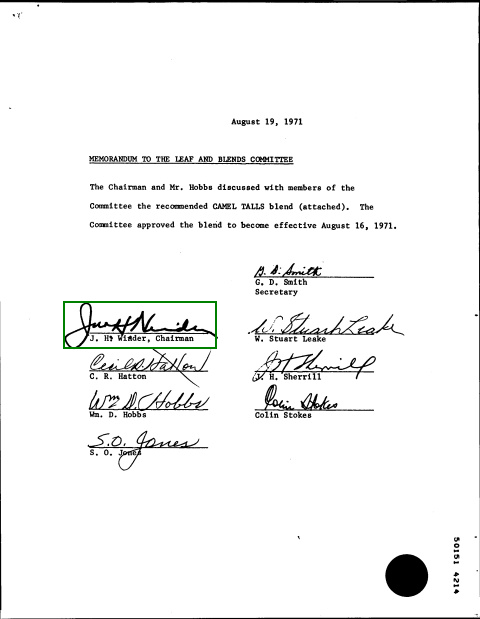

DLSignature (0.734)


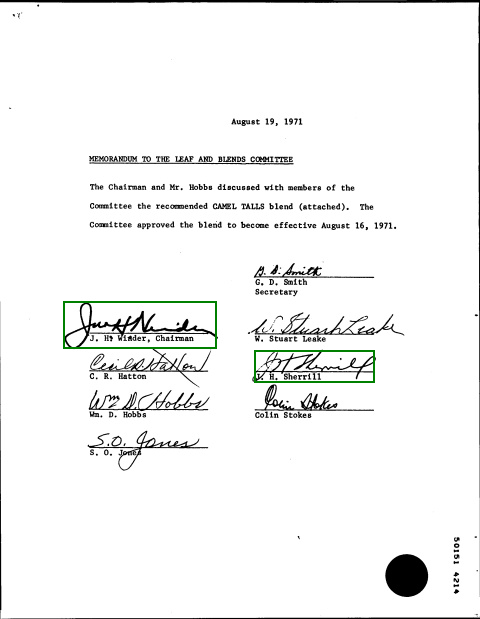

DLSignature (0.731)


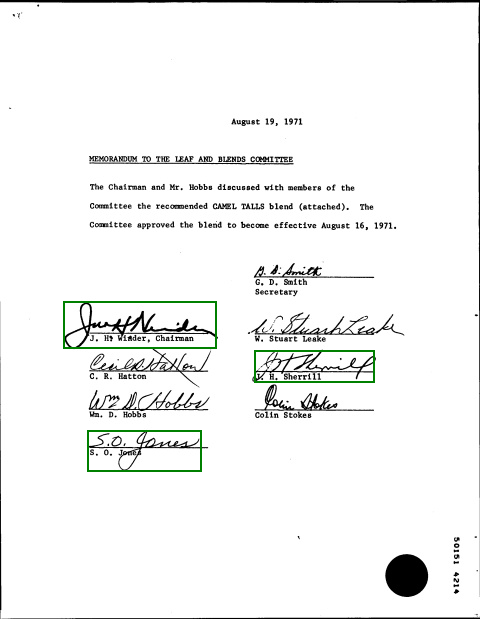

DLSignature (0.662)


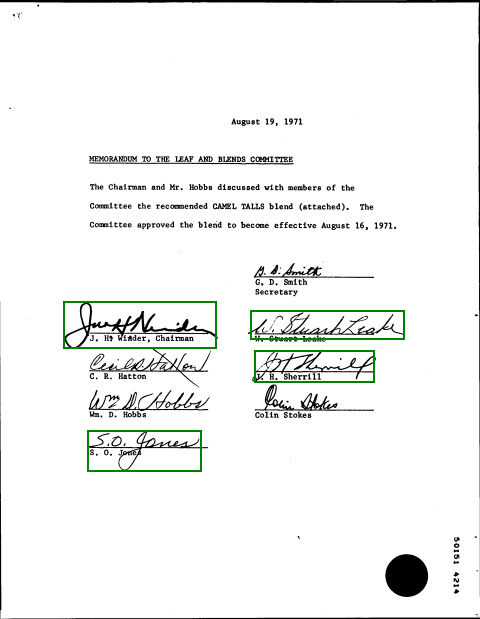

DLSignature (0.502)


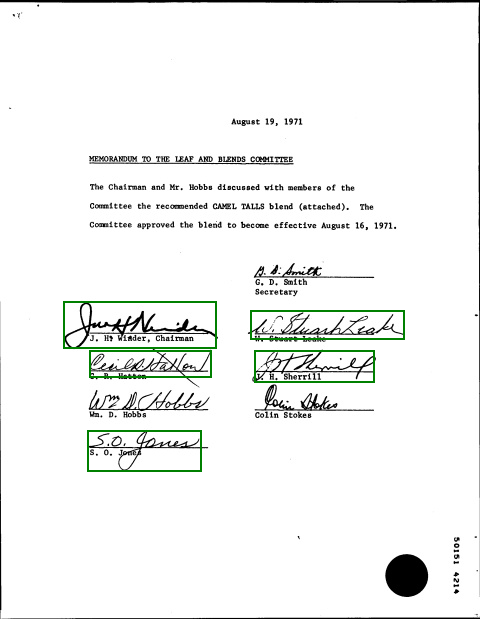

DLSignature (0.381)


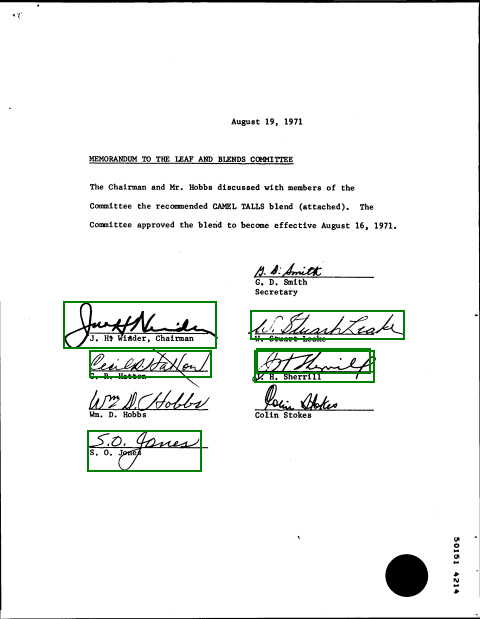

DLSignature (0.369)


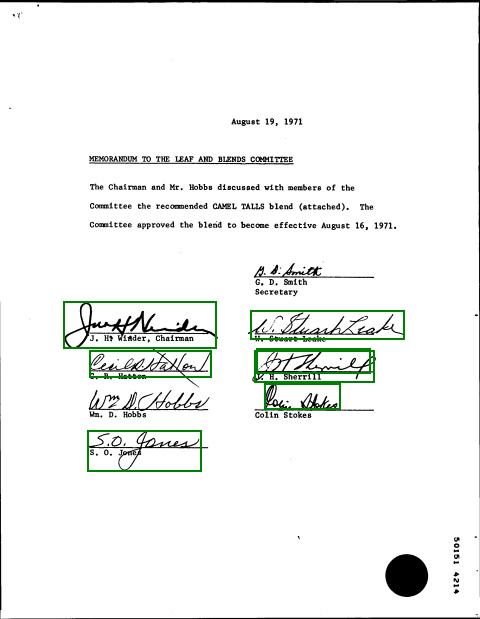

DLSignature (0.345)


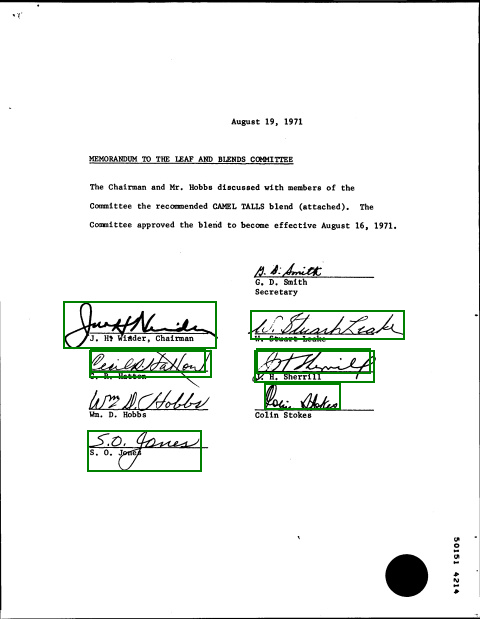

DLSignature (0.320)


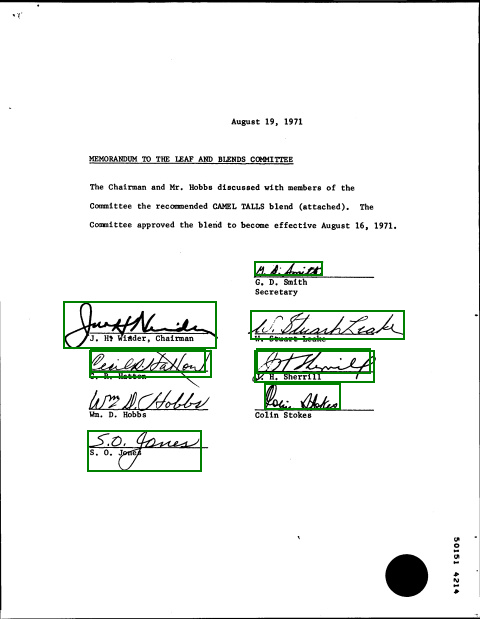

In [56]:
def draw_boxes_on_image(image_path, results):
    # Previsões das caixas delimitadoras a partir dos resultados do modelo
    predictions = results[0].boxes.data.tolist()

    # Carrega a imagem
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    # Labels e suas cores correspondentes
    labels = ["DLLogo", "DLSignature"]
    colors = ["red", "green"]

    # Itera sobre cada caixa delimitadora prevista
    for prediction in predictions:
        x1, y1, x2, y2, confidence, label = prediction

        # Converte a label para inteiro e valida
        label = int(label)
        if label >= len(labels):
            continue

        # Desenha a caixa delimitadora
        draw.rectangle([(x1, y1), (x2, y2)], outline=colors[label], width=2)

        # Texto com label e nível de confiança
        text = f'{labels[label]} ({confidence:.3f})'

        # Imprime o texto com label e nível de confiança
        print(text)

        # Exibe a imagem com as caixas delimitadoras
        display(image)

draw_boxes_on_image(test_image, yolo_test_results)